# Tutorial 002 - Unsupervised model in HCEs

A tutorial notebook for a simplified unsupervised model with real-world household data. 

In [2]:
# import necessary packages
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm


In [3]:
# read data from CSV file
datafile = Path('tutorial-data-0604.csv')
data = pd.read_csv(datafile)


### Mapping of variables used in modelling

```python
[
 'city_class', 'build_space', 'res_size', 'avg_age', 
 'res_income_percap', 'car_num', 'emits', 'emits_per', 'PV', 
 'if_single', 'if_single_kids', 'if_couple', 'if_couple_kids',
 'if_single_elderly', 'if_couple_elderly', 'if_big_family', 
 'if_others'
]
```

### Preprocessing

In [23]:
from sklearn.preprocessing import StandardScaler


def preprocessing(data: pd.DataFrame, vars: list):
    """data preprocessing and standardization"""
    zscore = StandardScaler()

    scaled = data.copy(True)
    for k in tqdm(vars, desc='Preprocssing'):
        var = scaled[k].fillna(0)
        scored = zscore.fit_transform(var.values.reshape(len(scaled), 1))
        scaled[k] = scored.reshape(len(scaled), )

    return scaled


def remove_negative_values(data: pd.DataFrame):
    """remove negative values in the table that must be invalid"""
    key4test = ['emits_per', 'res_income_percap']
    idx = []
    for k in key4test:
        foo = data[k]
        idx += list(foo[foo >= 0].index)
    
    idx = list(set(idx))
    out = data.iloc[idx, :]
    print(f'Ex-preprocessing: {len(data)}; Post-preprocessing: {len(out)}')
    return out
    

In [22]:
# use preprocessing approach to standardise data
keys4scale = ['build_space', 'res_income_percap', 'emits']
scaled = preprocessing(data, keys4scale)
scaled = remove_negative_values(scaled)


Preprocssing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 603.53it/s]

Ex-preprocessing: 500; Post-preprocessing: 500


### Clustering

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# customised function for iteration of a Kmeans++ clustering model
def clustering_modelling(data: pd.DataFrame, 
                         vars: list, 
                         epoch=10, 
                         display=True):
    """Modelling process for clustering"""
    # reconcile with features
    x = data[vars].fillna(0).values
    train = x.copy()  # could use fitted(post-lasso) or X (raw)

    # clustering pipeline
    param = {
        "n_clusters": 1,
        "init": "k-means++",
        "algorithm": "elkan",
        "random_state": 0
    }

    eva = []
    for n in tqdm(range(2, epoch, 1)):
        # baseline: K-Means, use n_cluster = 3 as default
        param["n_clusters"] = n
        km = KMeans(**param).fit(train)
        y_pred = km.predict(train)
        eva += [[silhouette_score(train, y_pred), davies_bouldin_score(train, y_pred)]]

    exp = pd.DataFrame(eva, columns=["silhouette_score", "calinski_harabasz_score"])
    print(exp)

    # for K-means, select the biggest sihouette_score
    n_clusters = exp.silhouette_score.values.argmax() + 2
    print(f"The finalised number of clusters is: {n_clusters}")

    # plot the iteration process
    if display:
        x_range = range(len(exp))
        fig = plt.figure(figsize=(10, 5), dpi=80)
        plt.plot(x_range, exp.silhouette_score.values, marker="^", color="darkgreen")
        plt.xticks(x_range, range(2, epoch, 1), size=12)

        plt.axvspan(n_clusters-2.5, n_clusters-1.5, 0, 0.975,
                    facecolor="none", edgecolor="red", linewidth=2, linestyle="--")
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")  # the higher, the better
        plt.grid(axis="y", color="grey", alpha=0.3)
        plt.savefig((f'cluster.png'), dpi=200)
        plt.show()

    # rerun the clustering model
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(train)
    y_pred = km.predict(train)

    # make sure you're passing `cluster` back to the raw dataset
    data["cluster"] = y_pred

    # statistics
    data['hid'] = range(len(data))
    counted = data[["hid", "cluster"]].groupby("cluster").count()
    print(f"Counted households: {counted}")

    # check the averaged percap emissions
    counted = data[["emits_per", "cluster"]].groupby("cluster").mean()
    print(f"Counted emission percap: {counted}")

    # output
    return data.copy(True)

In [26]:
# variables used in clustering excluding emissions and percap emissions

geo = ['city_class']
econ = ['build_space', 'res_income_percap', 'car_num']
demo = ['res_size', 'avg_age']
rel = ['if_single', 'if_single_kids', 'if_couple', 'if_couple_kids', 
       'if_single_elderly', 'if_couple_elderly', 'if_big_family', 
       'if_others']

#### (1) Demographic

  0%|                                                                                                                                                              | 0/8 [00:00<?, ?it/s]/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████████████████████▌                                                                                                                | 2/8 [00:00<00:00, 11.78it/s]/home/ubuntu/Documents/.local/share/vi

   silhouette_score  calinski_harabasz_score
0          0.417516                 0.853619
1          0.554379                 0.834627
2          0.658019                 0.801582
3          0.769006                 0.761198
4          0.857211                 0.684135
5          0.939625                 0.520657
6          1.000000                 0.000000
7          1.000000                 0.000000
The finalised number of clusters is: 8


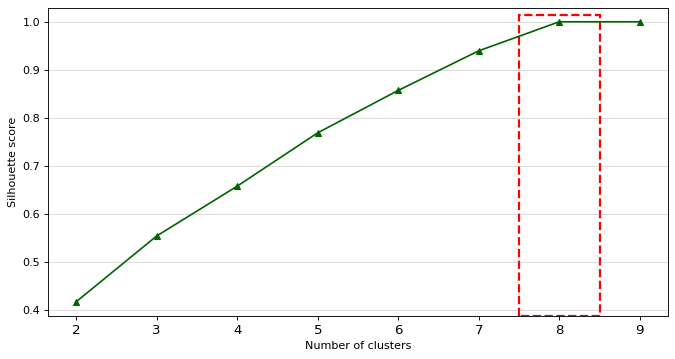

Counted households:          hid
cluster     
0         61
1        156
2         74
3         53
4         46
5         45
6         42
7         23
Counted emission percap:          emits_per
cluster           
0         2.236531
1         1.694193
2         2.350995
3         2.525364
4         1.980618
5         3.028574
6         1.439434
7         1.668419


/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
result = clustering_modelling(scaled, rel)


#### (2) Economic

  0%|                                                                                                                                                              | 0/8 [00:00<?, ?it/s]/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████████████████████▌                                                                                                                | 2/8 [00:00<00:00, 11.11it/s]/home/ubuntu/Documents/.local/share/vi

   silhouette_score  calinski_harabasz_score
0          0.304522                 1.365908
1          0.352266                 1.008378
2          0.323689                 1.018472
3          0.301442                 1.095727
4          0.313885                 1.051125
5          0.317045                 0.984432
6          0.326920                 1.002481
7          0.312693                 1.021134
The finalised number of clusters is: 3


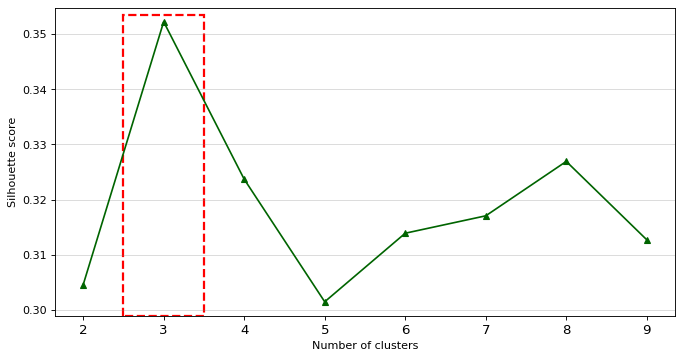

Counted households:          hid
cluster     
0        150
1        260
2         90
Counted emission percap:          emits_per
cluster           
0         2.548398
1         1.910621
2         1.730482


/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
result = clustering_modelling(scaled, econ)


#### (3) Scaled keys

  0%|                                                                                                                                                              | 0/8 [00:00<?, ?it/s]/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████████████████████▌                                                                                                                | 2/8 [00:00<00:00,  8.94it/s]/home/ubuntu/Documents/.local/share/vi

   silhouette_score  calinski_harabasz_score
0          0.334461                 1.258618
1          0.360155                 0.999495
2          0.304742                 1.107010
3          0.294496                 1.049524
4          0.301892                 1.049370
5          0.294367                 1.064959
6          0.272648                 1.082666
7          0.271928                 1.080847
The finalised number of clusters is: 3


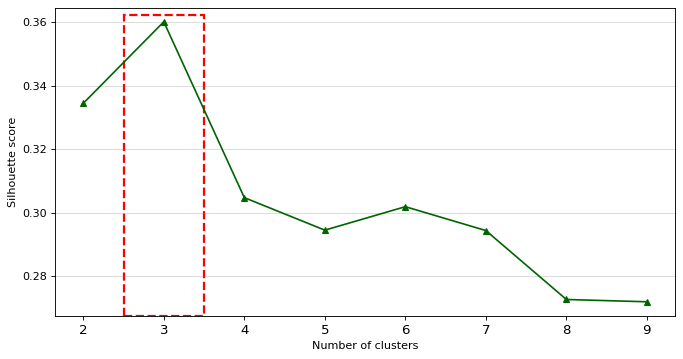

Counted households:          hid
cluster     
0        127
1         87
2        286
Counted emission percap:          emits_per
cluster           
0         3.024562
1         1.494384
2         1.820398


/home/ubuntu/Documents/.local/share/virtualenvs/utokyo-lecture-01-p9SbEPUQ/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
result = clustering_modelling(scaled, keys4scale)
